# Managing Big Data for Connected Devices

## 420-N63-NA

## Kawser Wazed Nafi
 ----------------------------------------------------------------------------------------------------------------------------------

# Linear Regression

In this we'll make use of the California Housing data set.

The data contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). In this sample a block group on average includes 1425.5 individuals living in a geographically compact area.

These spatial data contain 20,640 observations on housing prices with 9 economic variables:

#### Longitude
refers to the angular distance of a geographic place north or south of the earth’s equator for each block group

#### Latitude 
refers to the angular distance of a geographic place east or west of the earth’s equator for each block group

#### Housing Median Age
is the median age of the people that belong to a block group. Note that the median is the value that lies at the midpoint of a frequency distribution of observed values
#### Total Rooms
is the total number of rooms in the houses per block group

#### Total Bedrooms
is the total number of bedrooms in the houses per block group

#### Population
is the number of inhabitants of a block group

#### Households
refers to units of houses and their occupants per block group

#### Median Income
is used to register the median income of people that belong to a block group

#### Median House Value
is the dependent variable and refers to the median house value per block group

In [1]:
# Install dependent libraries
!pip install mllib
!pip install pandas
!pip install numpy

In [2]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

In [3]:
# Spark Session Creation

ss = SparkSession.builder.master("local[4]").appName("Linear-Regression").getOrCreate()
sc = ss.sparkContext
sqlContext = SQLContext(sc)

# Load data from file into dataframe
HOUSING_DATA = 'input/cal_housing.data'
# define the schema, corresponding to a line in the csv data file.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)
# Load housing data
housing_df = ss.read.csv(path=HOUSING_DATA, schema=schema).cache()

# Inspect first five rows
housing_df.take(5)

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [4]:
# show the dataframe columns
housing_df.columns

# show the schema of the dataframe
housing_df.printSchema()

# run a sample selection
housing_df.select('pop','totbdrms').show(10)

# group by housingmedianage and see the distribution
result_df = housing_df.groupBy("medage").count().sort("medage", ascending=False)

result_df.show(10)

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



<AxesSubplot: xlabel='medage'>

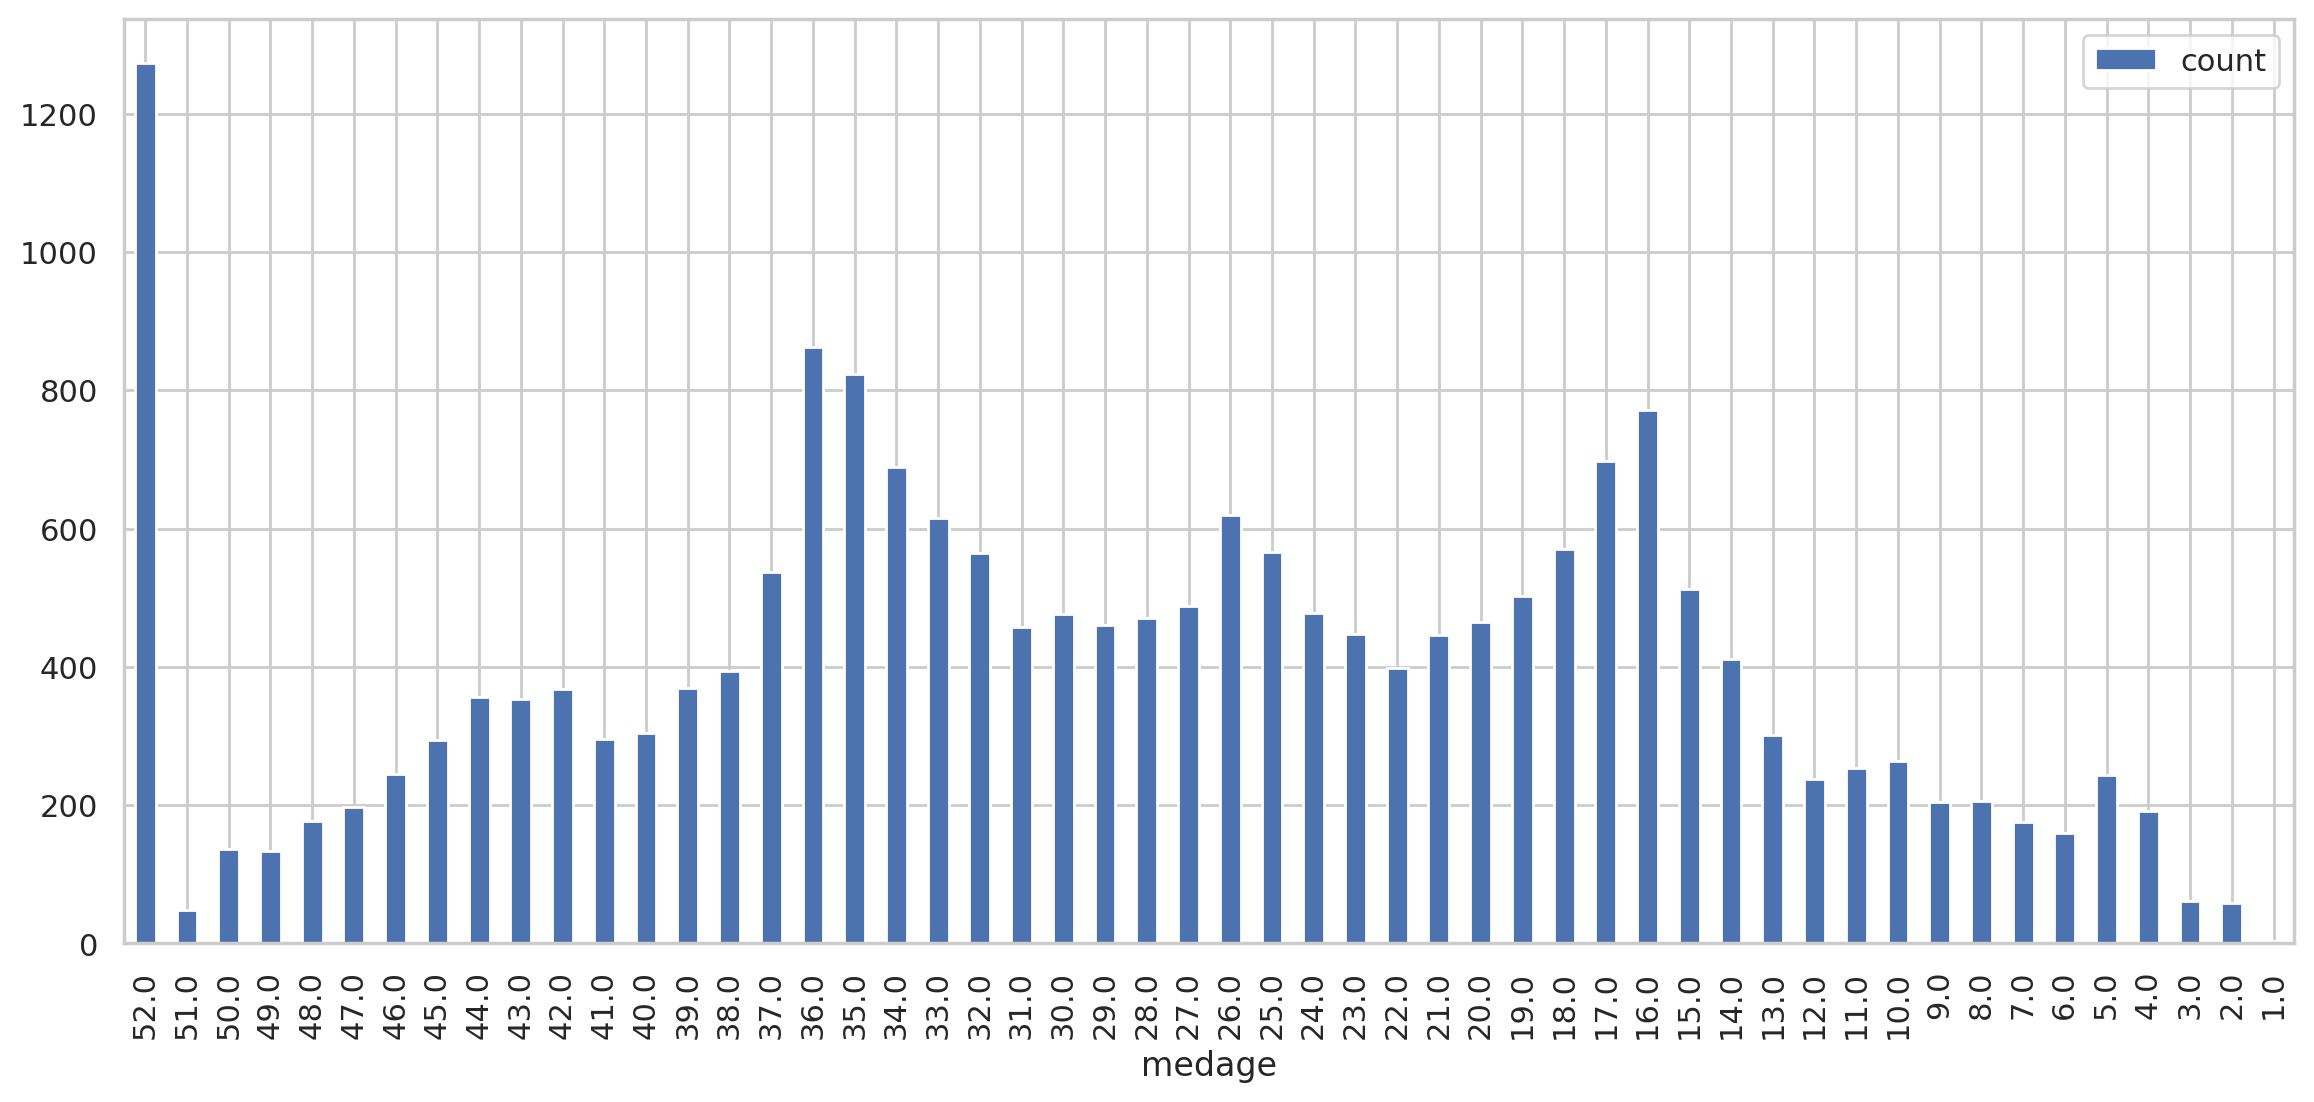

In [5]:
# plot the sample on a graph

result_df.toPandas().plot.bar(x='medage',figsize=(14, 6))

## Summary Statistics

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [6]:
(housing_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



Look at the minimum and maximum values of all the (numerical) attributes. We see that multiple attributes have a wide range of values: we will need to normalize your dataset.

### Data Preprocessing

5. Data Preprocessing
With all this information that we gathered from our small exploratory data analysis, we know enough to preprocess our data to feed it to the model.

1. we shouldn't care about missing values; all zero values have been excluded from the data set.
2. We should probably standardize our data, as we have seen that the range of minimum and maximum values is quite big.
3. There are possibly some additional attributes that we could add, such as a feature that registers the number of bedrooms per room or the rooms per household.
4. Our dependent variable is also quite big; To make our life easier, we'll have to adjust the values slightly.

#### Preprocessing The Target Values
First, let's start with the medianHouseValue, our dependent variable. To facilitate our working with the target values, we will express the house values in units of 100,000. That means that a target such as 452600.000000 should become 4.526:

In [7]:
# Adjust the values of `medianHouseValue`
housing_df = housing_df.withColumn("medhv", col("medhv")/100000)
housing_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



## Feature Engineering / Selection from Sample

Now that we have adjusted the values in medianHouseValue, we will now add the following columns to the data set:

1. Rooms per household which refers to the number of rooms in households per block group;
2. Population per household, which basically gives us an indication of how many people live in households per block group; And
3. Bedrooms per room which will give us an idea about how many rooms are bedrooms per block group;

As we're working with DataFrames, we can best use the select() method to select the columns that we're going to be working with, namely totalRooms, households, and population. Additionally, we have to indicate that we're working with columns by adding the col() function to our code. Otherwise, we won't be able to do element-wise operations like the division that we have in mind for these three variables:

In [8]:
housing_df.columns

# Add the new columns to `df`
housing_df = (housing_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

# Inspect the result
housing_df.show(5)

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



We can see that, for the first row, there are about 6.98 rooms per household, the households in the block group consist of about 2.5 people and the amount of bedrooms is quite low with 0.14:

Since we don't want to necessarily standardize our target values, we'll want to make sure to isolate those in our data set. Note also that this is the time to leave out variables that we might not want to consider in our analysis. In this case, let's leave out variables such as longitude, latitude, housingMedianAge and totalRooms.

In this case, we will use the select() method and passing the column names in the order that is more appropriate. In this case, the target variable medianHouseValue is put first, so that it won't be affected by the standardization.

In [9]:
# Re-order and select columns
housing_df = housing_df.select("medhv", 
                               "medage",
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

In [10]:
#### Feature Extraction

featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]

# Use a VectorAssembler to put features into a feature vector column:

# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 
assembled_df = assembler.transform(housing_df)
assembled_df.show(10, truncate=False)

+-----+------+--------+------+--------+------+--------+--------+----------+------------------------------------------------------------+
|medhv|medage|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                                    |
+-----+------+--------+------+--------+------+--------+--------+----------+------------------------------------------------------------+
|4.526|41.0  |129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15,41.0]   |
|3.585|21.0  |1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16,21.0]|
|3.521|52.0  |190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13,52.0]    |
|3.413|52.0  |235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18,52.0]   |
|3.422|52.0  |280.0   |565.0 |259.0   |3.

#### Standarization

Next, we can finally scale the data using StandardScaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "features_scaled":

In [11]:
# Initialize the `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# Fit the DataFrame to the scaler
scaled_df = standardScaler.fit(assembled_df).transform(assembled_df)
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                    |features_scaled                                                                                                                                          |
+------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15,41.0]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697,3.2577023016083064]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16,21.0]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.3695679991

In [12]:
## Building the ML model

# Split the data into train and test sets
train_data, test_data = scaled_df.randomSplit([.8,.2], seed=rnd_seed)
train_data.columns


['medhv',
 'medage',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_scaled']

#### Creating and ElasticNet model

ElasticNet is a linear regression model trained with L1 and L2 prior as regularizer. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of L1 and L2 using the l1_ratio parameter.

Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

A practical advantage of trading-off between Lasso and Ridge is it allows Elastic-Net to inherit some of Ridge’s stability under rotation.



In [13]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='features_scaled', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))
# Fit the data to the model
linearModel = lr.fit(train_data)


In [14]:
## Evaluating the model
# Coefficients for the model
linearModel.coefficients



DenseVector([0.0, 0.0, 0.0, 0.5293, 0.0, 0.0, 0.0, 0.0])

In [15]:
featureCols

# Intercept for the model
linearModel.intercept

coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

['totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'medage']

0.9939730178200581

In [16]:
coeff_df

,Feature,Co-efficients
0,Intercept,0.993973
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.529268
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000
8,medage,0.000000


#### Generating Predictions


In [17]:
# Generate predictions

predictions = linearModel.transform(test_data)


# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("medage", "predmedhv", "medhv")

predandlabels.show()



+------+------------------+-------+
|medage|         predmedhv|  medhv|
+------+------------------+-------+
|  16.0|1.4566243897688356|0.14999|
|  52.0|1.2145312774490895|  0.225|
|  52.0|1.2981355800828176|  0.225|
|  46.0| 1.605613327174062|  0.269|
|  22.0|1.5917675552433308|  0.344|
|  31.0|1.2861005664625962|  0.367|
|  10.0|1.4945681188009723|  0.375|
|  42.0|1.4238067035065887|  0.394|
|  36.0|1.5262714335000702|  0.398|
|  28.0|1.5674746204799597|  0.409|
|  27.0|1.3207012140155836|  0.417|
|  16.0|1.4553985976545207|  0.425|
|  52.0|1.1878703819884848|  0.425|
|  39.0|  1.43174648880927|   0.43|
|  40.0|1.2560409124575578|  0.436|
|  17.0|  1.32964391711995|   0.44|
|  42.0| 1.591098899095143|   0.44|
|  29.0|1.4288770193957463|  0.444|
|  32.0|1.3638824063687758|  0.445|
|  38.0| 1.518498828839585|  0.446|
+------+------------------+-------+
only showing top 20 rows



### Model Data Visualization

The model tried to predict the median house values (medhv) based on the data given. We are now going to visualize the trained predicted data and the actual data we fed in the model.

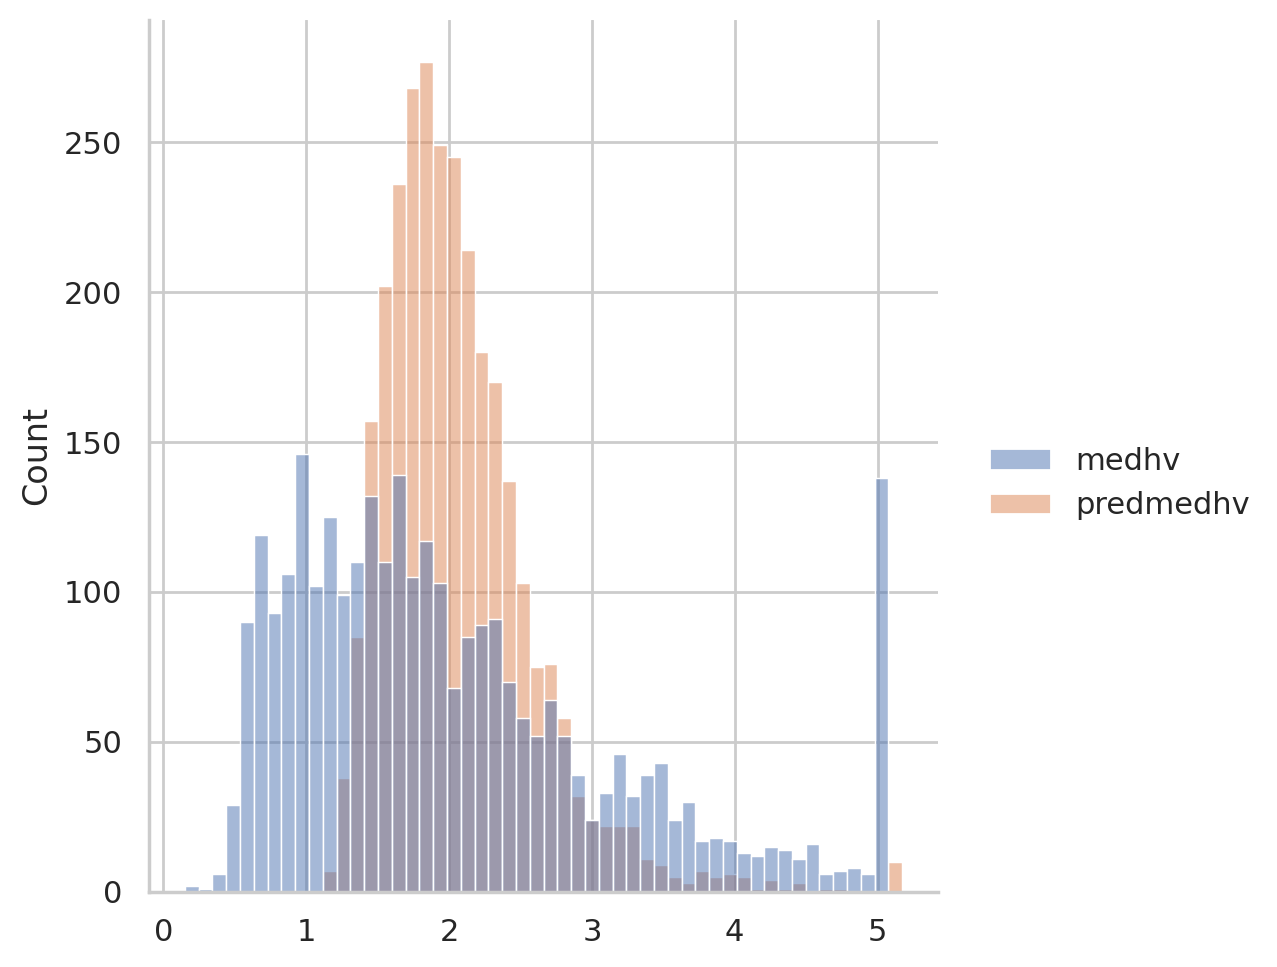

In [18]:
import seaborn as sns
medhv_df = predictions.select(['medhv', 'predmedhv']).sample(False, 0.7, 42)
medhv_pandas_df = medhv_df.toPandas()
sns.displot(medhv_pandas_df)

<AxesSubplot: xlabel='medage', ylabel='medhv'>

<AxesSubplot: xlabel='medage', ylabel='medhv'>

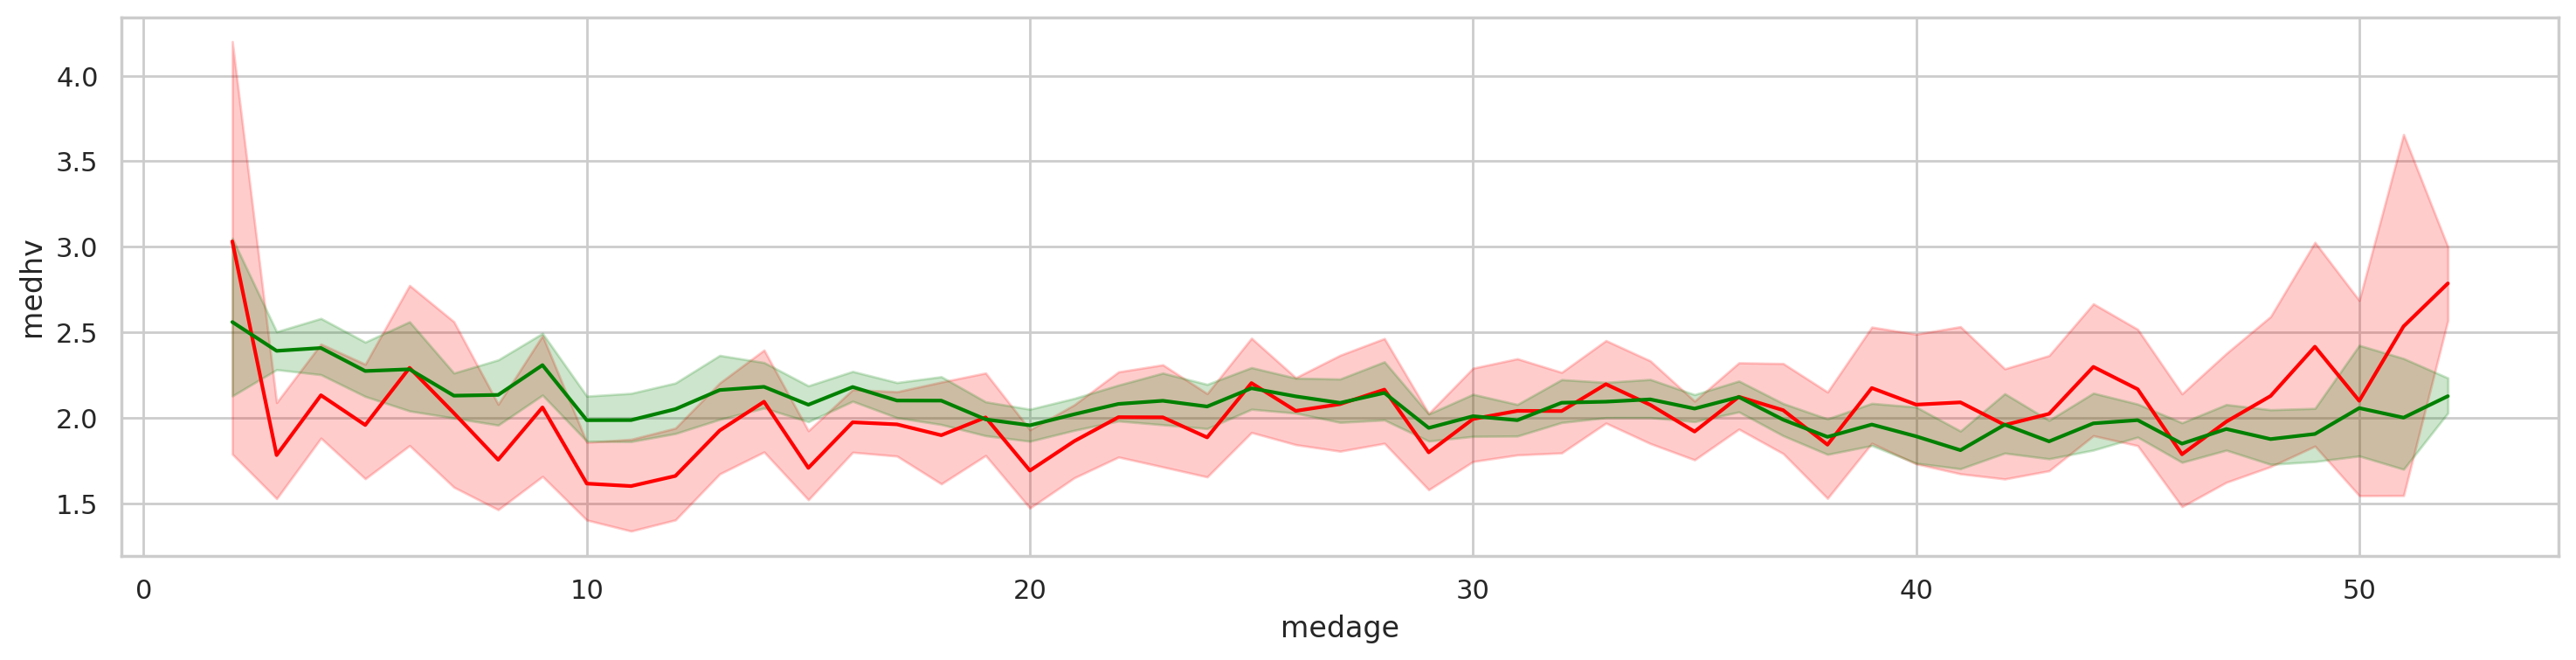

In [19]:
medhv2_df = predictions.select(['medage','medhv', 'predmedhv']).sample(False, 0.7, 42)
medhv2_pandas_df = medhv2_df.toPandas()
sns.lineplot(x="medage", y="medhv", data = medhv2_pandas_df, color="red")
sns.lineplot(x="medage", y="predmedhv", data = medhv2_pandas_df, color="green")

### Inspect the Metrics


In [20]:
# Get the RMSE (root mean square error)
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

# Get Mean Average Error (MAE)
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

# Get the R2 (R square error)
print("R2: {0}".format(linearModel.summary.r2))

RMSE: 0.878969772131949
MAE: 0.6755195682813134
R2: 0.4220577199800566


#### Regression Evaluator from PySpark Package



In [21]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.8751096322709987
MAE: 0.6789520880603118
R2: 0.4153580431458296


In [22]:
#### Regression Metrics from MLLIB Package

# mllib is old so the methods are available in rdd
metrics = RegressionMetrics(predandlabels.rdd)

print("RMSE: {0}".format(metrics.rootMeanSquaredError))

print("MAE: {0}".format(metrics.meanAbsoluteError))

print("R2: {0}".format(metrics.r2))

/usr/local/spark/python/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


RMSE: 29.970939317595253
MAE: 27.044356823086495
R2: -2293.9578072926065


## Exercise 1

Can you explain why do we need RMSE, MAE and R2? What is the purpose of using these metrics?

RMSE shows the average difference between the projected values and the actual responses, it is used to calculate how dispersed the data points are from the regression line.
<br>
MAE shows the average of all absolute errors present in the dataset/group of predictions, to find out the magnitude between the projected values and the true values. 
<br>
R2 measures a fraction of the variance of the values from the response variable not captured by the regression model.

## Exercise 2

Can you plot the predicted dataframe on plot? Medage and count predicted plot will be enough to see.

+------+-------+------------------+
|medage|  medhv|         predmedhv|
+------+-------+------------------+
|  16.0|0.14999|1.4566243897688356|
|  52.0|  0.225|1.2145312774490895|
|  46.0|  0.269| 1.605613327174062|
|  22.0|  0.344|1.5917675552433308|
|  31.0|  0.367|1.2861005664625962|
|  42.0|  0.394|1.4238067035065887|
|  27.0|  0.417|1.3207012140155836|
|  16.0|  0.425|1.4553985976545207|
|  52.0|  0.425|1.1878703819884848|
|  42.0|   0.44| 1.591098899095143|
|  29.0|  0.444|1.4288770193957463|
|  32.0|  0.445|1.3638824063687758|
|   9.0|   0.45|1.6075356056666323|
|  45.0|  0.462|1.4538942375571422|
|  25.0|  0.469|1.4011853426930907|
|  20.0|  0.471| 1.507801061095143|
|  33.0|  0.474|1.6467050936027858|
|  26.0|  0.478|1.3749701958577458|
|  26.0|  0.481| 1.751398566722566|
|  35.0|  0.486|1.4780199584680187|
+------+-------+------------------+
only showing top 20 rows

+------+-----+
|medage|count|
+------+-----+
|  18.0|   72|
|  47.0|   29|
|   9.0|   33|
|  39.0|   52|
|   5

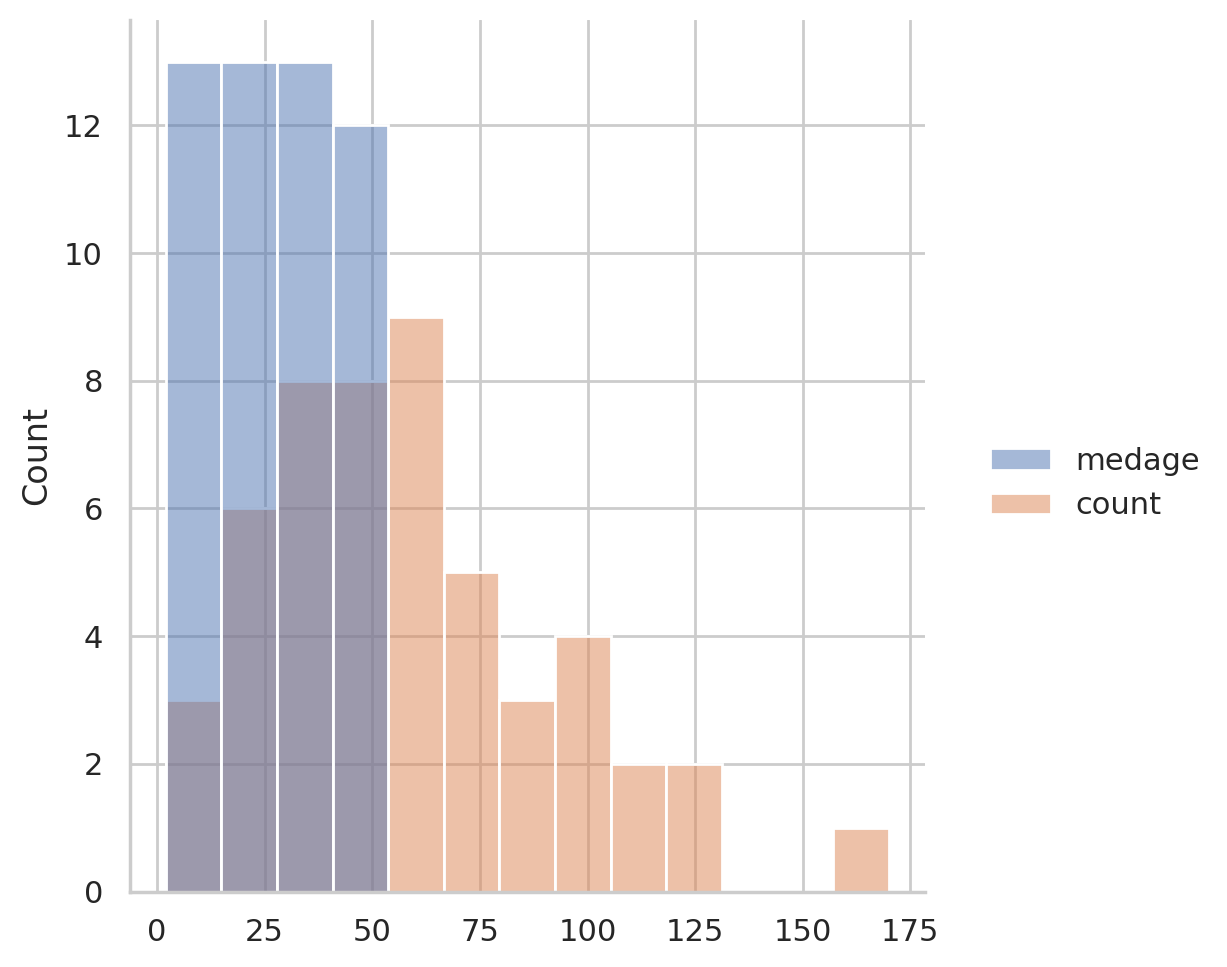

In [23]:
medhv2_df.show()
medhv2_df_count = medhv2_df.groupBy('medage').count()
medhv2_df_count.show()
medhv2_df_count_pandas = medhv2_df_count.toPandas()
sns.displot(medhv2_df_count_pandas)

## Exercise 3

Can we redo the whole process of our highly used Movie Ratings dataset? Please join Movies.csv and Ratings.csv together. Then establish the relationship between the users and movie ratings. Select which features we can use for linear regression. Explain why did you choose them.

In [48]:
movies_path = './Movies/movies.csv'
ratings_path = './Movies/ratings.csv'
movies_df = ss.read.csv(movies_path, header=True, inferSchema=True)
ratings_df = ss.read.csv(ratings_path, header=True, inferSchema=True)

joined_df = movies_df.join(ratings_df, 'movieId')

avg_ratings_df = joined_df.groupBy('movieId').agg(F.avg(col('rating')).alias('avgRating'))
avg_ratings_df.show()

+-------+------------------+
|movieId|         avgRating|
+-------+------------------+
|   1580| 3.487878787878788|
|   2366|              3.64|
|   3175|              3.58|
|   1088| 3.369047619047619|
|  32460|              4.25|
|  44022| 3.217391304347826|
|  96488|              4.25|
|   1238| 4.055555555555555|
|   1342|               2.5|
|   1591|2.6346153846153846|
|   1645| 3.411764705882353|
|   4519|3.3333333333333335|
|   2142|               2.7|
|    471|              3.55|
|   3997|1.8333333333333333|
|    833|               2.0|
|   3918|3.2777777777777777|
|   7982|              3.25|
|   1959|3.6666666666666665|
|  68135|              3.55|
+-------+------------------+
only showing top 20 rows



In [51]:
feature_cols = ["avgRating","movieId"]

mr_assember = VectorAssembler(inputCols=feature_cols, outputCol="features")
mr_assembler_df = mr_assember.transform(avg_ratings_df)
mr_assembler_df.show(10, truncate=False)

+-------+------------------+---------------------------+
|movieId|avgRating         |features                   |
+-------+------------------+---------------------------+
|1580   |3.487878787878788 |[3.487878787878788,1580.0] |
|2366   |3.64              |[3.64,2366.0]              |
|3175   |3.58              |[3.58,3175.0]              |
|1088   |3.369047619047619 |[3.369047619047619,1088.0] |
|32460  |4.25              |[4.25,32460.0]             |
|44022  |3.217391304347826 |[3.217391304347826,44022.0]|
|96488  |4.25              |[4.25,96488.0]             |
|1238   |4.055555555555555 |[4.055555555555555,1238.0] |
|1342   |2.5               |[2.5,1342.0]               |
|1591   |2.6346153846153846|[2.6346153846153846,1591.0]|
+-------+------------------+---------------------------+
only showing top 10 rows



In [52]:
mr_standard = StandardScaler(inputCol="features", outputCol="features_scaled")
mr_scaler_df = mr_standard.fit(mr_assembler_df).transform(mr_assembler_df)
mr_scaler_df.select('features','features_scaled').show(truncate=False)

+---------------------------+-----------------------------------------+
|features                   |features_scaled                          |
+---------------------------+-----------------------------------------+
|[3.487878787878788,1580.0] |[4.009638468847947,0.030273339136307056] |
|[3.64,2366.0]              |[4.184515837341576,0.04533336733955854]  |
|[3.58,3175.0]              |[4.115540301561221,0.060834083390996774] |
|[3.369047619047619,1088.0] |[3.873031076555684,0.020846451253355745] |
|[4.25,32460.0]             |[4.885767117775192,0.6219446761800804]   |
|[3.217391304347826,44022.0]|[3.6986881505408102,0.8434765414294362]  |
|[4.25,96488.0]             |[4.885767117775192,1.8487430041670856]   |
|[4.055555555555555,1238.0] |[4.662235288857372,0.023720502437182364] |
|[2.5,1342.0]               |[2.8739806575148186,0.025713177924635486]|
|[2.6346153846153846,1591.0]|[3.0287334621502318,0.030484102889787673]|
|[3.411764705882353,1645.0] |[3.9221383090790463,0.0315187613159

In [53]:
mr_train_data, mr_test_data = mr_scaler_df.randomSplit([.8,.2], seed=rnd_seed)
mr_train_data.columns

['movieId', 'avgRating', 'features', 'features_scaled']

In [54]:
lr = (LinearRegression(featuresCol='features_scaled', labelCol="avgRating", predictionCol='predRating', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))
# Fit the data to the model
linearModel = lr.fit(mr_train_data)


In [55]:
linearModel.coefficients

DenseVector([0.5877, 0.0])

In [56]:
linearModel.intercept

1.0605783315779789

In [57]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + feature_cols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})

In [58]:
coeff_df = coeff_df[["Feature", "Co-efficients"]]
coeff_df

,Feature,Co-efficients
0,Intercept,1.060578
1,avgRating,0.587659
2,movieId,0.000000


In [60]:
mr_predictions = linearModel.transform(mr_test_data)
pred_labels = mr_predictions.select("movieId","predRating")
pred_labels.show()

+-------+------------------+
|movieId|        predRating|
+-------+------------------+
|      1|3.7094322244803535|
|      8| 3.002835523215322|
|      9| 3.171727452922917|
|     12|2.6961633350620575|
|     24| 3.171727452922917|
|     28|3.9163873248154952|
|     29|3.7717382558314783|
|     41| 3.560178891250386|
|     43| 3.213950435349816|
|     49|3.0872814880691197|
|     55|   3.7628492068995|
|     63| 2.894262139831868|
|     69|3.6108464701626644|
|     75|2.5468273130048154|
|     83|3.0872814880691197|
|     92| 2.833943593507727|
|     94| 3.729070820957981|
|     97|3.6952924350164613|
|    100|2.9425169768911807|
|    102|2.6819408567708916|
+-------+------------------+
only showing top 20 rows



<AxesSubplot: xlabel='movieId', ylabel='predRating'>

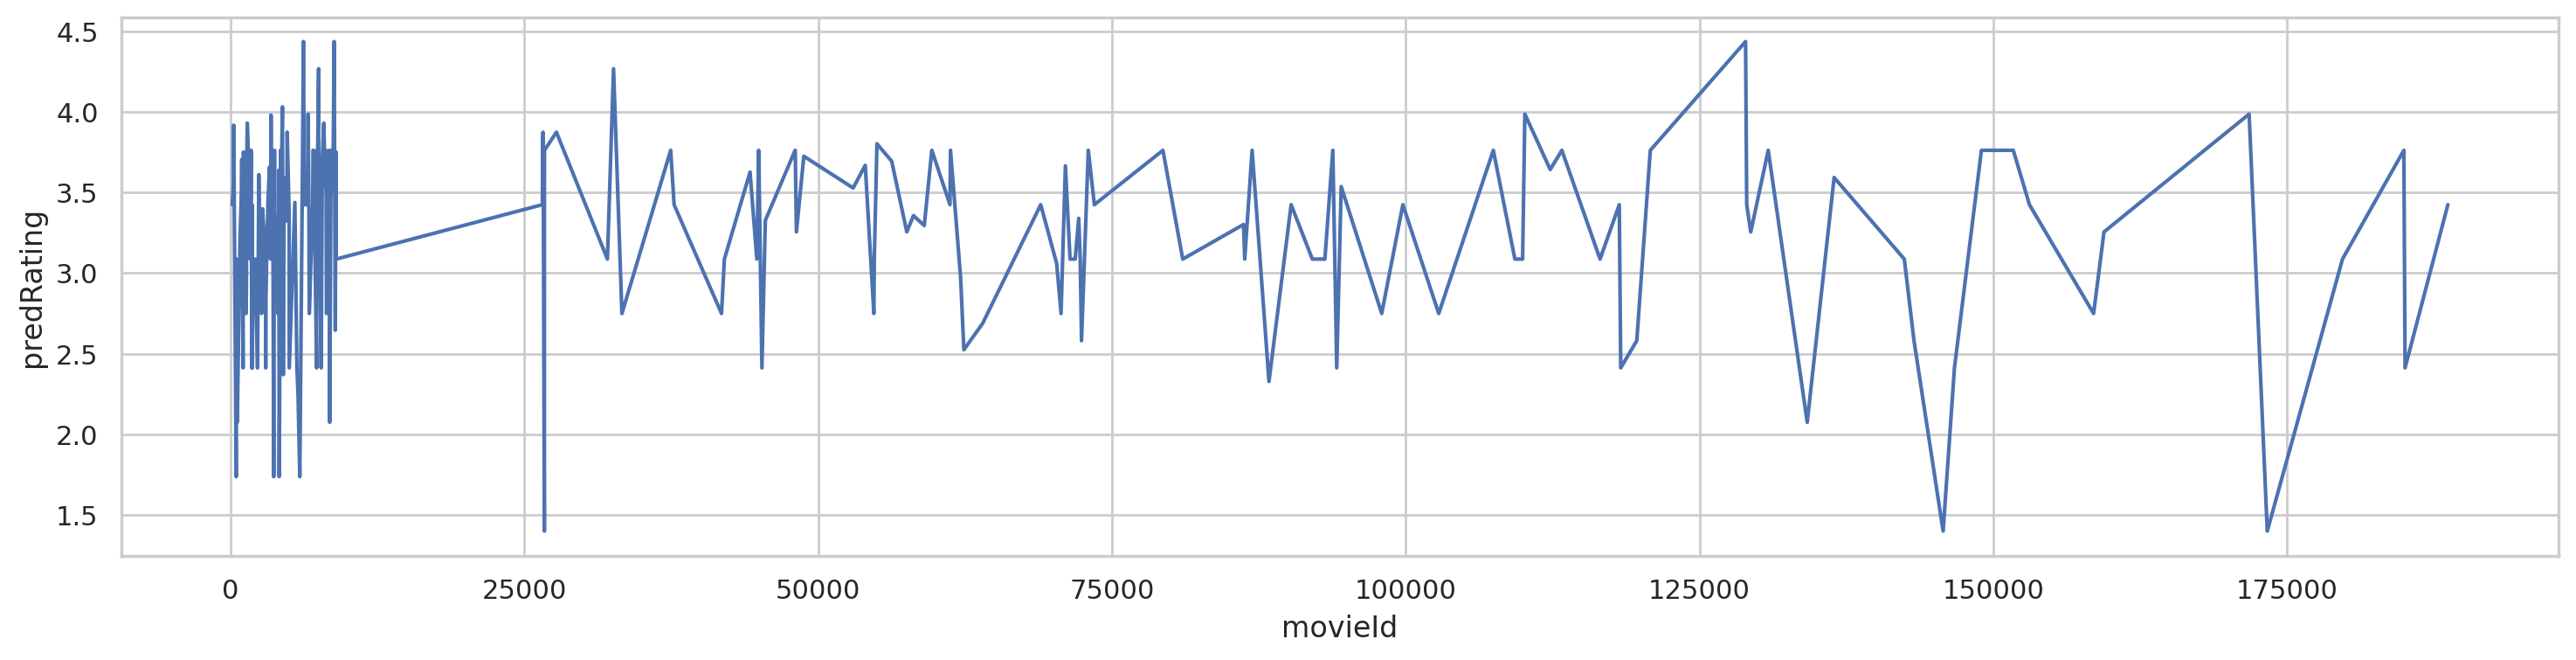

In [62]:
mr_preds_df = mr_predictions.select(["movieId","predRating"]).sample(False, 0.1, 25)
mr_preds_pandas_df = mr_preds_df.toPandas()
sns.lineplot(x='movieId',y='predRating',data=mr_preds_pandas_df)

"movieId" and "rating" are the only 2 numerical data that can be easily integrated to the model.

## Decision Tree Regression

Decision trees are a popular family of classification and regression methods. More information about the spark.ml implementation can be found further in the section on decision trees.
<a>https://en.wikipedia.org/wiki/Decision_tree_learning</a>

In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator

Once the training is done with the labeled data, we need to perform predictions with the test data, to see whether our model trains perfectl or not.



In [36]:
## Tree Visualization
!pip install -q dtreeviz

In [37]:

# Adjust the values of `medianHouseValue`
#### Feature Extraction

featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]
target = "medhv"

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

(trainingData, testData) = housing_df.randomSplit([0.8, 0.2])

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(trainingData) for column in featureCols]

stages = indexers

#featureIndexer =\
#    VectorIndexer(inputCol= ,outputCol="indexedFeatures").fit(housing_df)


# Split the data into training and test sets (30% held out for testing)



## Model Creation
vector_assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
stages.append(vector_assembler)
decision_tree = DecisionTreeRegressor(featuresCol="features", labelCol=target, predictionCol="premedhv")
stages.append(decision_tree)
pipeline = Pipeline().setStages(stages)
model = pipeline.fit(trainingData)


#dt = DecisionTreeRegressor(featuresCol="indexedFeatures")

# Chain indexer and tree in a Pipeline
#pipeline = Pipeline(stages=[featureIndexer, dt])

# Train model.  This also runs the indexer.
#model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("medage","premedhv", "medhv","features").show(5)


+------+------------------+-----+--------------------+
|medage|          premedhv|medhv|            features|
+------+------------------+-----+--------------------+
|  46.0|0.9279181834010451|0.269|[543.0,1423.0,482...|
|  29.0|1.3183120762976857|0.283|[3114.0,12427.0,2...|
|  14.0|1.3159328743545609|0.329|[386.0,436.0,213....|
|  26.0|0.9279181834010451|0.366|[199.0,567.0,204....|
|  10.0|1.3159328743545609|0.375|[102.0,140.0,49.0...|
+------+------------------+-----+--------------------+
only showing top 5 rows



### Decision Tree Regression Visualization



<AxesSubplot: xlabel='medage', ylabel='medhv'>

<AxesSubplot: xlabel='medage', ylabel='medhv'>

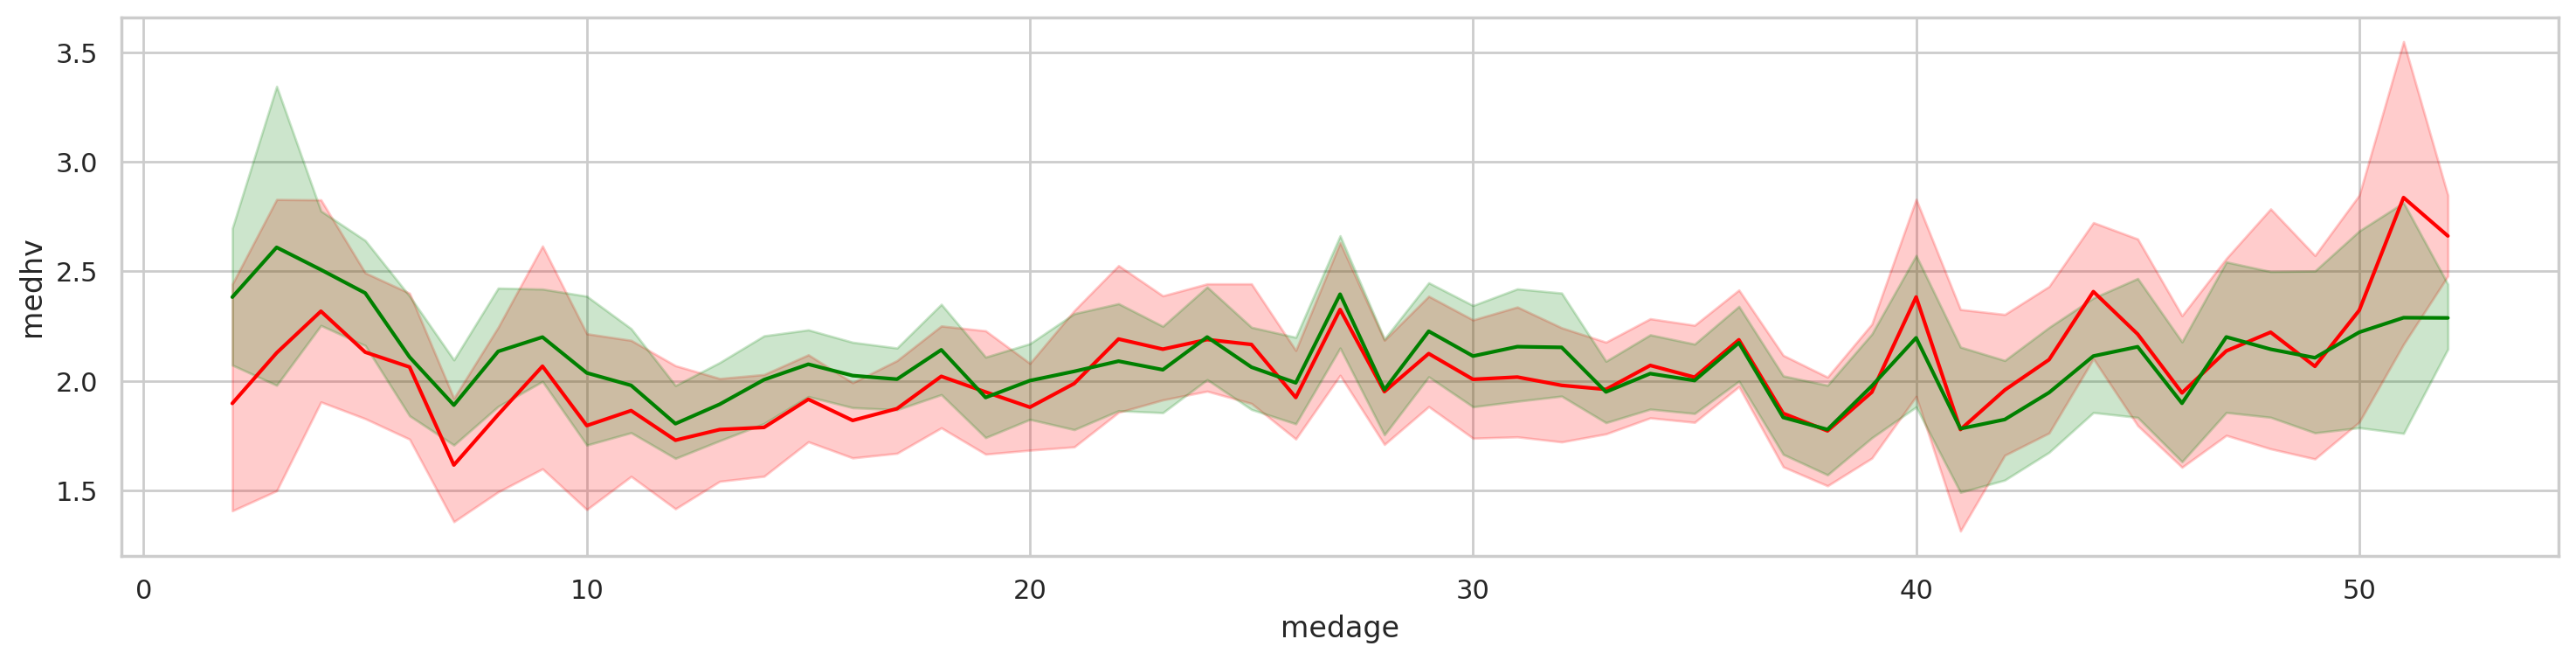

In [38]:
medhv_df = predictions.select(['medage','medhv', 'premedhv']).sample(False, 0.7, 42)
medhv_pandas_df = medhv_df.toPandas()
sns.lineplot(x="medage", y="medhv", data = medhv_pandas_df, color="red")
sns.lineplot(x="medage", y="premedhv", data = medhv_pandas_df, color="green")

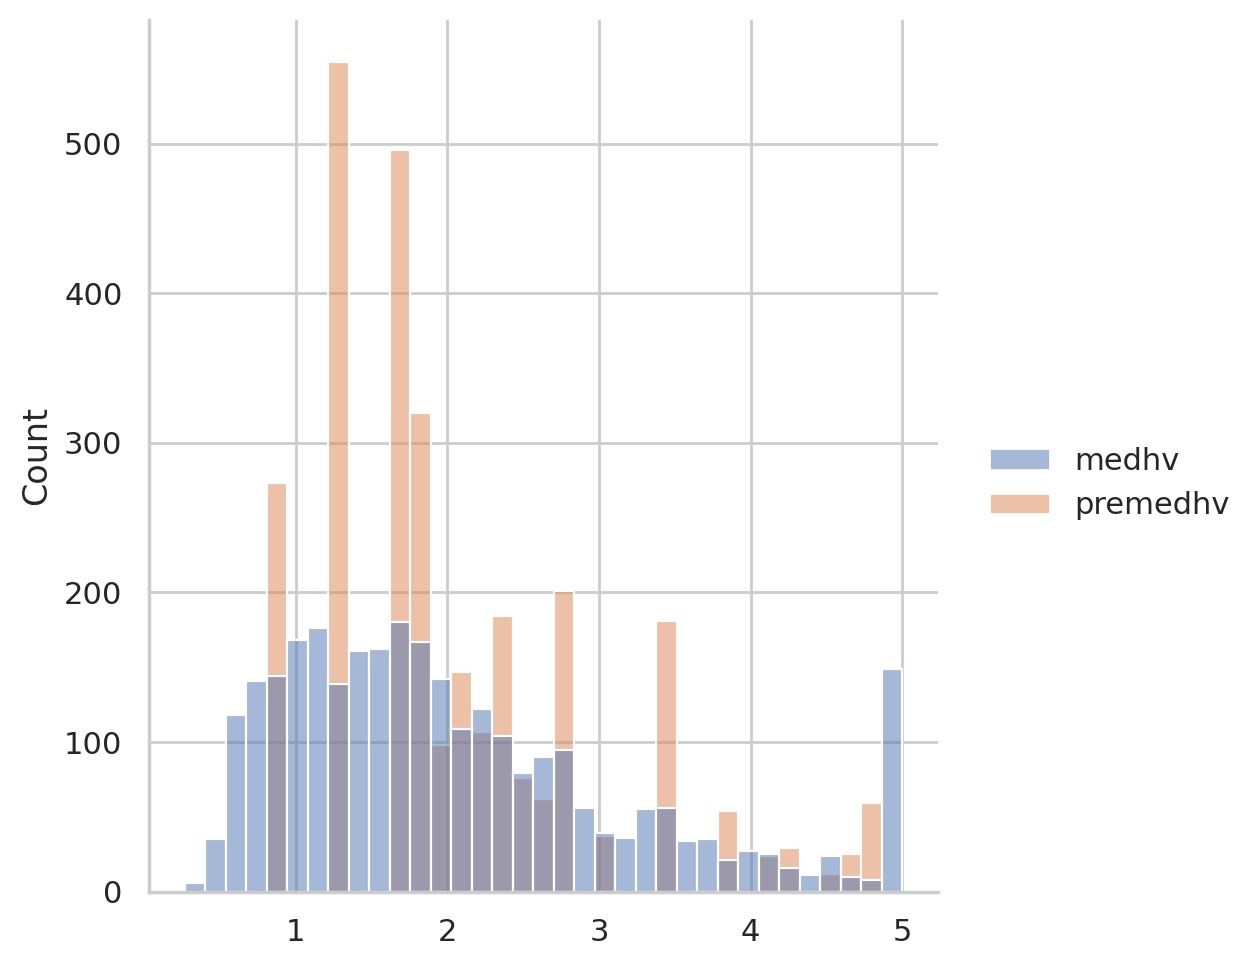

In [39]:
medhv_df = predictions.select(['medhv', 'premedhv']).sample(False, 0.7, 42)
medhv_pandas_df = medhv_df.toPandas()
sns.displot(medhv_pandas_df)

### RandomForest Regressor



In [40]:
from pyspark.ml.regression import RandomForestRegressor


# Adjust the values of `medianHouseValue`
#### Feature Extraction

featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm", "medage"]
target = "medhv"

# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.

(trainingData, testData) = housing_df.randomSplit([0.8, 0.2])

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(trainingData) for column in featureCols]
stages = indexers

#featureIndexer =\
#    VectorIndexer(inputCol= ,outputCol="indexedFeatures").fit(housing_df)


# Split the data into training and test sets (30% held out for testing)



## Model Creation
vector_assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
stages.append(vector_assembler)
randomForestrg = RandomForestRegressor(featuresCol="features", labelCol=target, predictionCol="predmedhv")
stages.append(randomForestrg)
pipeline = Pipeline().setStages(stages)
model = pipeline.fit(trainingData)
# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("medage","predmedhv", "medhv","features").show(5)


+------+------------------+-----+--------------------+
|medage|         predmedhv|medhv|            features|
+------+------------------+-----+--------------------+
|  33.0|1.3609752429570383|0.225|[73.0,216.0,63.0,...|
|  34.0|1.2025209464628097|0.266|[309.0,808.0,294....|
|  23.0|1.6883837002067843|  0.3|[448.0,338.0,182....|
|  39.0|1.2306575420912542| 0.35|[1747.0,6852.0,15...|
|  14.0|1.3934247015306824|0.375|[650.0,5723.0,615...|
+------+------------------+-----+--------------------+
only showing top 5 rows



<AxesSubplot: xlabel='medage', ylabel='medhv'>

<AxesSubplot: xlabel='medage', ylabel='medhv'>

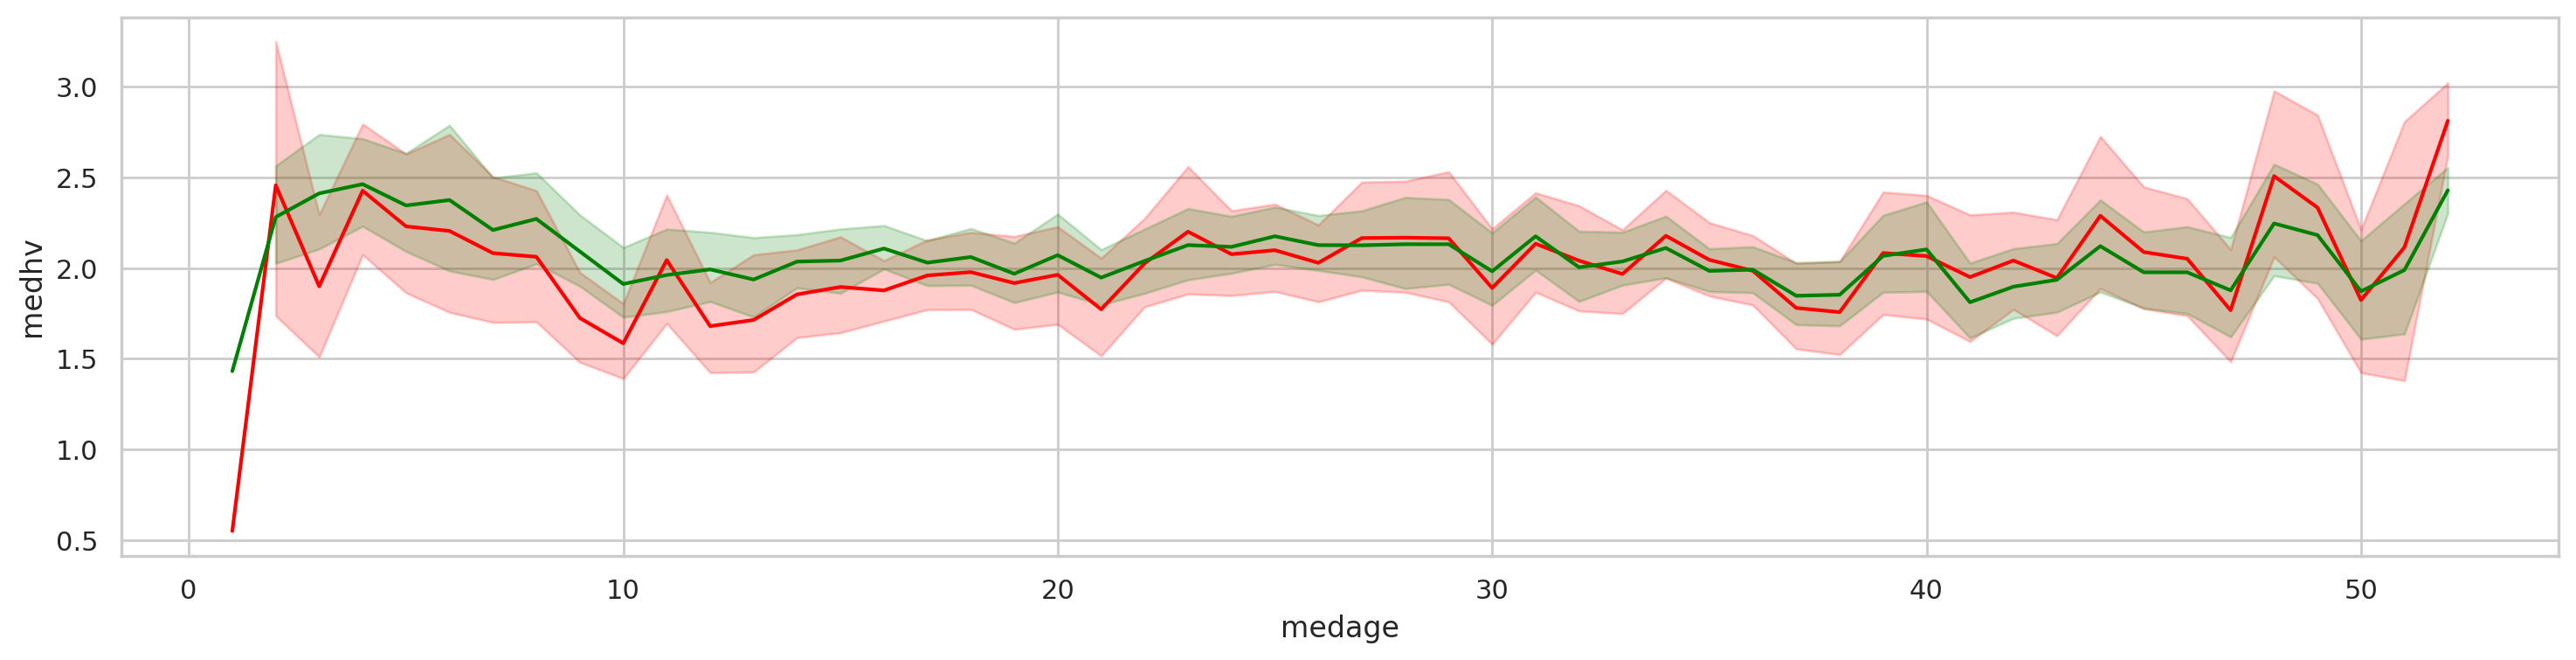

In [41]:
medhv_df = predictions.select(['medage','medhv', 'predmedhv']).sample(False, 0.7, 42)
medhv_pandas_df = medhv_df.toPandas()
sns.lineplot(x="medage", y="medhv", data = medhv_pandas_df, color="red")
sns.lineplot(x="medage", y="predmedhv", data = medhv_pandas_df, color="green")

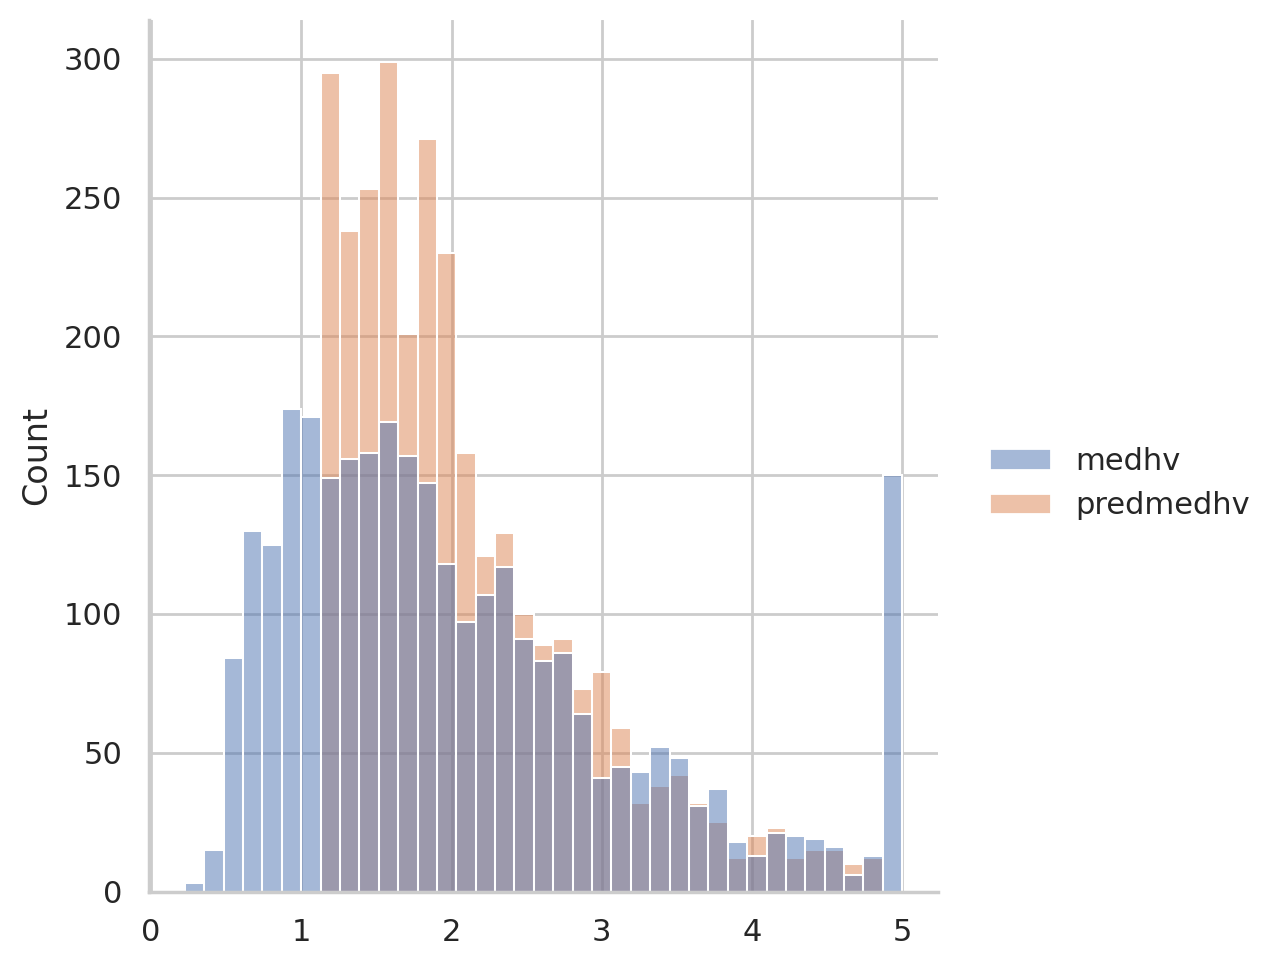

In [42]:
medhv_df = predictions.select(['medhv', 'predmedhv']).sample(False, 0.7, 42)
medhv_pandas_df = medhv_df.toPandas()
sns.displot(medhv_pandas_df)

## Exercise 4
Which regression model do you think the best fit for the given data? And why do you think?

The random forest model is the more accurate model out of the two, since it requires evaluating multiple decision trees simultaneously.

## Exercise 5
Redo Exercise 3, but this time plot the prediction data with the true data on a line plot to show how strong your model has regressed.

<AxesSubplot: >

<AxesSubplot: >

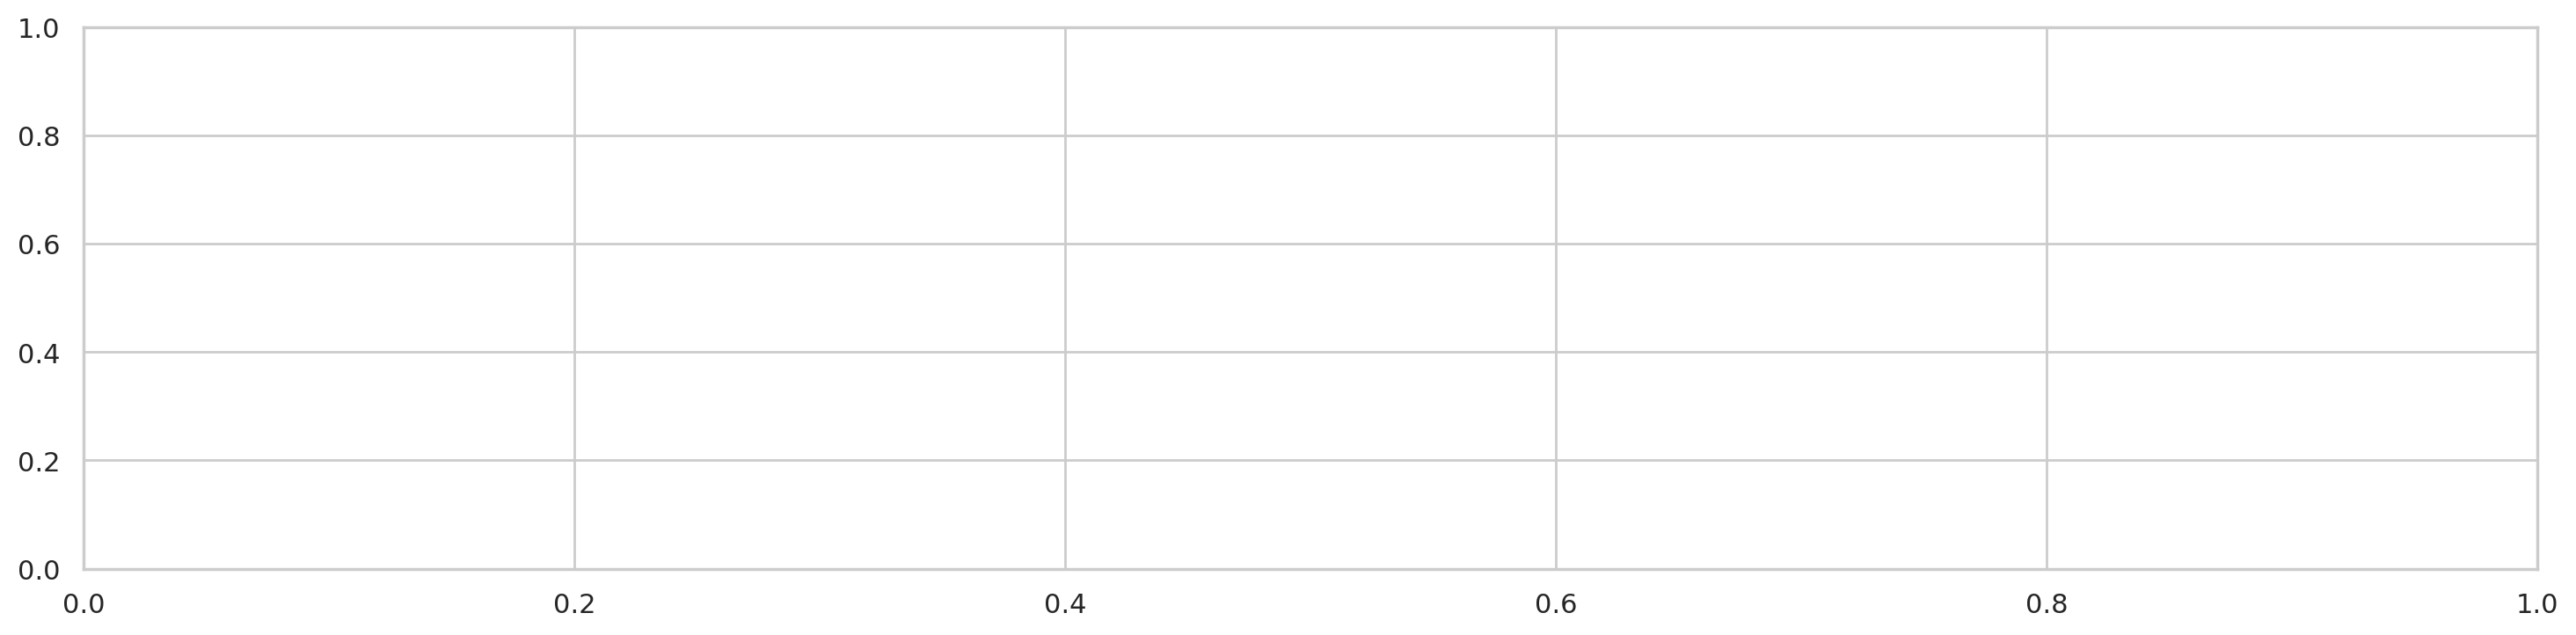

In [43]:
mr_full_df = avg_ratings_df.select('userId','avgRating').sample(False, 0.1, 25).join(mr_preds_df, 'userId')
mr_full_pandas = mr_full_df.toPandas()
sns.lineplot(x = 'userId', y = 'avgRating', data = mr_full_pandas, color = "orange")
sns.lineplot(x = 'userId', y = 'predRating', data = mr_full_pandas, color = "purple")

## Exercise 6
Redo 3 & 5 but with Decision Tree Regression.

In [44]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator


+------+------------------+------------------+--------------------+
|userId|        predRating|         avgRating|            features|
+------+------------------+------------------+--------------------+
|    13| 3.667571489490344|3.6451612903225805|[13.0,3.645161290...|
|    25|  4.76264189886481|4.8076923076923075|[25.0,4.807692307...|
|    26|3.2530035328882985| 3.238095238095238|[26.0,3.238095238...|
|    36| 2.746752973274853|2.6333333333333333|[36.0,2.633333333...|
|    39|3.9843076154570753|               4.0|          [39.0,4.0]|
+------+------------------+------------------+--------------------+
only showing top 5 rows



<AxesSubplot: xlabel='userId', ylabel='avgRating'>

<AxesSubplot: xlabel='userId', ylabel='avgRating'>

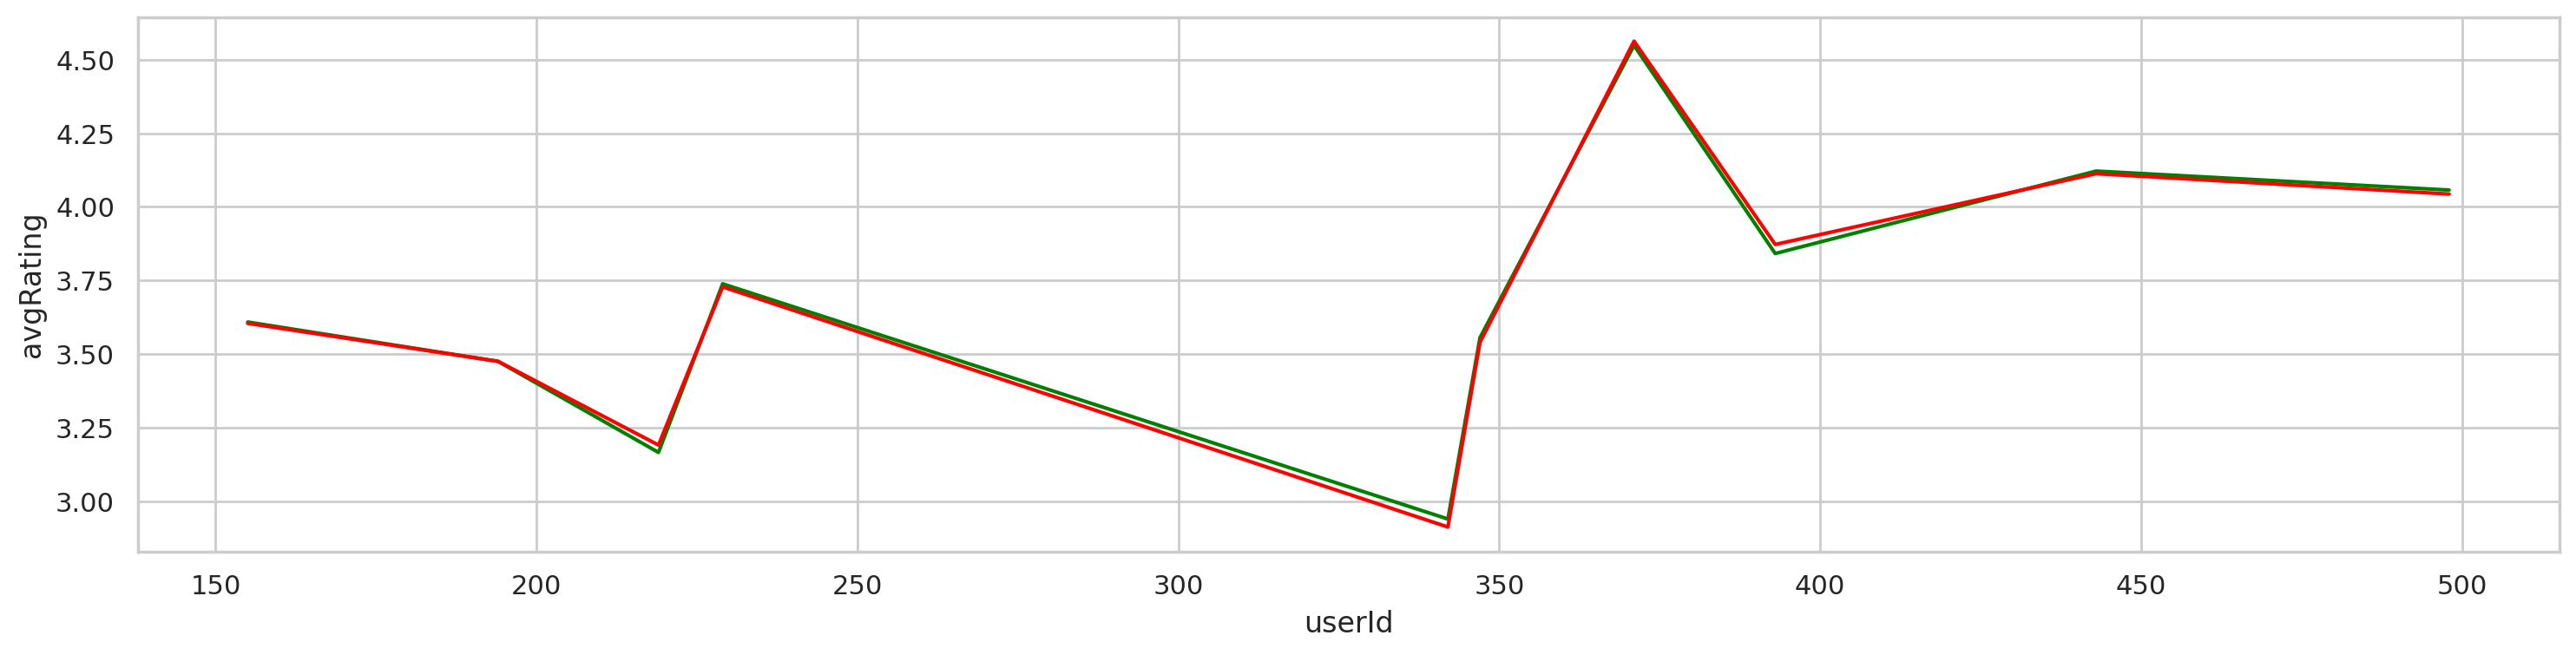

In [45]:
featureDTR = ["userId", "avgRating"]
target = "avgRating"

(trainingData, testingData) = avg_ratings_df.randomSplit([0.7, 0.1])
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(trainingData) for column in featureDTR]

stages = indexers
vector_assembler = VectorAssembler(inputCols=featureDTR, outputCol="features")
stages.append(vector_assembler)
decision_tree = DecisionTreeRegressor(featuresCol="features", labelCol=target, predictionCol="predRating")
stages.append(decision_tree)
pipeline = Pipeline().setStages(stages)
model = pipeline.fit(trainingData)

predictions = model.transform(testingData)

predictions.select("userId","predRating", "avgRating","features").show(5)

pred_df = predictions.select(['userId','avgRating', 'predRating']).sample(False, 0.1, 10)
pred_pandas_df = pred_df.toPandas()
sns.lineplot(x="userId", y="avgRating", data = pred_pandas_df, color="green")
sns.lineplot(x="userId", y="predRating", data = pred_pandas_df, color="red")


## Exercise 7
Redo 3 & 5 but with Random Forest Regression.

In [46]:
from pyspark.ml.regression import RandomForestRegressor


In [47]:
featureDTR = ["userId", "avgRating"]
target = "avgRating"

(trainingData, testingData) = mr_true.randomSplit([0.7, 0.1])
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(trainingData) for column in featureDTR]
stages = indexers

vector_assembler = VectorAssembler(inputCols=featureDTR, outputCol="features")
stages.append(vector_assembler)

decision_tree = RandomForestRegressor(featuresCol="features", labelCol=target, predictionCol="predRating")
stages.append(decision_tree)

pipeline = Pipeline().setStages(stages)
model = pipeline.fit(trainingData)

predictions = model.transform(testingData)

predictions.select("userId","predRating", "avgRating","features").show(5)

pred_df = predictions.select(['userId','avgRating', 'predRating']).sample(False, 0.1, 10)
pred_pandas_df = pred_df.toPandas()
sns.lineplot(x="userId", y="avgRating", data = pred_pandas_df, color="green")
sns.lineplot(x="userId", y="predRating", data = pred_pandas_df, color="red")

NameError: name 'mr_true' is not defined